In [1]:
# import the required packages
import numpy as np
import pandas as pd

import nltk
import re
import string
# for visualizations
import matplotlib.pyplot as plt
# for market basket analysis
# conda install -c conda-forge mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Problem1

## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [2]:
dat = pd.read_csv('bbc-text.csv')

In [3]:
dat.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
dat['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

### 1.2 Cleanse the Text Data

In [6]:
dat['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [7]:

nltk.download('wordnet')
nltk.download('stopwords')
def pre_process(text):
    
    #lowercase
    text.lower()
    
    #remove tags
    text = re.sub("<\?.*?>"," <> ", text)
    
    #remove punctuations
    text = "".join([char for char in text if char not in string.punctuation])
    #remove special characters and digits
    text = re.sub("(\\d|\\W|_)+"," ",text)
    
    return text

def get_stopwords(stop_file_path):
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
stopwords = get_stopwords("stopwords.txt")

dat['text_preprocessed'] = dat['text'].apply(lambda x:pre_process(x))

def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

dat['text_nopunct'] = dat['text_preprocessed'].apply(lambda x:remove_punct(x))

def tokenize (text):
    tokens = re.split('\W+', text)
    return tokens

dat['text_tokenized'] = dat['text_nopunct'].apply(lambda x: tokenize(x))

stopword_nltk = nltk.corpus.stopwords.words('english')
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword_nltk]
    return text

dat['text_nostop'] = dat['text_tokenized'].apply(lambda x: remove_stopwords(x))

wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text] 
    return text

dat['text_lemmatized']  = dat['text_nostop'].apply(lambda x: lemmatizing(x))

def join_text(tokenized_text):
    text = " ".join(tokenized_text)
    return text

dat['text_joined'] = dat['text_lemmatized'].apply(lambda x:join_text(x))
text_all = dat['text_joined']
text_all[0]

<>:9: DeprecationWarning: invalid escape sequence \?
<>:35: DeprecationWarning: invalid escape sequence \W
<>:9: DeprecationWarning: invalid escape sequence \?
<>:35: DeprecationWarning: invalid escape sequence \W
C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/27194854.py:9: DeprecationWarning: invalid escape sequence \?
  text = re.sub("<\?.*?>"," <> ", text)
C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/27194854.py:35: DeprecationWarning: invalid escape sequence \W
  tokens = re.split('\W+', text)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gwenx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gwenx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'tv future hand viewer home theatre system plasma highdefinition tv digital video recorder moving living room way people watch tv radically different five year time according expert panel gathered annual consumer electronics show la vega discus new technology impact one favourite pastime u leading trend programme content delivered viewer via home network cable satellite telecom company broadband service provider front room portable device one talkedabout technology ce digital personal video recorder dvr pvr settop box like u tivo uk sky system allow people record store play pause forward wind tv programme want essentially technology allows much personalised tv also builtin highdefinition tv set big business japan u slower take europe lack highdefinition programming people forward wind advert also forget abiding network channel schedule putting together alacarte entertainment u network cable satellite company worried mean term advertising revenue well brand identity viewer loyalty chann

In [8]:
text_all.shape

(2225,)

### 1.3 Bag-of-Word

In [9]:
#create a vocabulary of words,
#ignore words that appear in 15% of documents,
#eliminate stop words
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(max_df=0.15,stop_words=stopwords, max_features=10000)
text_counts = count_vect.fit_transform(text_all.tolist())


In [10]:
text_counts.shape

(2225, 10000)

In [11]:
count_vect.stop_words_


{'animate',
 'safari',
 'berthinussen',
 'cristie',
 'indecent',
 'shea',
 'restoration',
 'stellar',
 'appreciation',
 'jogging',
 'verified',
 'twofold',
 'ukif',
 'benita',
 'importer',
 'postquake',
 'wobble',
 'ariadne',
 'declan',
 'hut',
 'dishevelled',
 'threehour',
 'occasional',
 'britneys',
 'idris',
 'lausanne',
 'maeve',
 'bluntly',
 'activated',
 'unchartered',
 'gascoigne',
 'sontaya',
 'tin',
 'vendetta',
 'shakur',
 'brookstein',
 'ashvin',
 'battlestar',
 'twogoal',
 'bloomberg',
 'collaboratively',
 'perceives',
 'enduser',
 'separated',
 'exukip',
 'sovlink',
 'reside',
 'cherney',
 'olga',
 'structured',
 'harty',
 'vague',
 'popularise',
 'condesending',
 'baptist',
 'mammoth',
 'mistyeyed',
 'firstpersonviewed',
 'coasted',
 'lamine',
 'entitles',
 'habitat',
 'jena',
 'netted',
 'tightlyknit',
 'manly',
 'touchyfeely',
 'thx',
 'everitt',
 'gangsterstyle',
 'lob',
 'impromptu',
 'darkly',
 'legitimately',
 'dil',
 'nascent',
 'veritable',
 'overhyped',
 'bonny',

In [12]:
sum_words = text_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [13]:
print('The highest frequency words:')
words_freq[0:20] 


The highest frequency words:


[('film', 1113),
 ('bn', 955),
 ('music', 835),
 ('labour', 796),
 ('party', 778),
 ('sale', 734),
 ('election', 702),
 ('technology', 669),
 ('mobile', 633),
 ('england', 616),
 ('phone', 604),
 ('blair', 599),
 ('award', 595),
 ('report', 577),
 ('public', 555),
 ('system', 552),
 ('european', 541),
 ('tax', 540),
 ('british', 533),
 ('tv', 522)]

In [14]:
print('The lowest frequency words:')
words_freq[-20:]

The lowest frequency words:


[('darlington', 4),
 ('transmit', 4),
 ('blb', 4),
 ('mohdsaaid', 4),
 ('curbishley', 4),
 ('deeley', 4),
 ('cduk', 4),
 ('synergy', 4),
 ('narbonne', 4),
 ('prechristmas', 4),
 ('nationalist', 4),
 ('lita', 4),
 ('sukul', 4),
 ('iea', 4),
 ('pctvt', 4),
 ('materialist', 4),
 ('neath', 4),
 ('defect', 4),
 ('lebanon', 4),
 ('cepes', 4)]

In [15]:
count_vect.get_feature_names()

['aaa',
 'aac',
 'aaliyah',
 'aaron',
 'abandoned',
 'abandoning',
 'abandonment',
 'abba',
 'abbas',
 'abbasi',
 'abbott',
 'abc',
 'aberdeen',
 'ability',
 'able',
 'abn',
 'abolish',
 'abolished',
 'abolishing',
 'abortion',
 'abortionist',
 'abramovich',
 'abroad',
 'absa',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorbing',
 'absurd',
 'abuse',
 'abused',
 'abusing',
 'abusive',
 'ac',
 'academic',
 'academy',
 'acc',
 'accelerate',
 'accelerated',
 'accelerating',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accessible',
 'accessing',
 'accession',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'acclaim',
 'acclaimed',
 'accolade',
 'accommodate',
 'accommodation',
 'accompanied',
 'accompanying',
 'accomplished',
 'according',
 'account',
 'accountability',
 'accountable',
 'accountancy',
 'accountant',
 'accounted',
 'accounting',
 'accuracy',
 'accurate',
 'accurately',
 'accusation',
 'accu

In [16]:
feature_names=np.array(count_vect.get_feature_names())
len(count_vect.get_feature_names())

10000

In [17]:
pd.DataFrame(text_counts.toarray()).to_csv('Gwendolyn_BoW.csv')
pd.DataFrame(text_counts.toarray())


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 TF-IDF

In [18]:
# Generate TF-IDF Matrix

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
text_tfidf = tfidf_transformer.fit_transform(text_counts)


In [19]:
tfidf_transformer.idf_


array([5.93537281, 7.60934924, 8.01481435, ..., 6.91620206, 5.99991133,
       7.60934924])

In [20]:
tfidf_transformer.idf_.shape

(10000,)

In [21]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
 feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['according' 'move' 'help' 'public' 'bn' 'director' 'sale' 'report' 'six'
 'third' 'international' 'record' 'issue' 'british' 'business' 'look'
 'start' 'despite' 'decision' 'mean' 'life' 'cost' 'london' 'change'
 'european' 'film' 'future' 'seen' 'result' 'money' 'figure' 'spokesman'
 'lot' 'deal' 'claim' 'executive' 'run' 'analyst' 'industry' 'earlier'
 'called' 'star' 'party' 'britain' 'share' 'taking' 'saying' 'action'
 'system' 'national' 'able' 'yearold' 'hope' 'due' 'europe' 'team'
 'leader' 'le' 'lost' 'recent' 'england' 'past' 'technology' 'biggest'
 'found' 'office' 'labour' 'level' 'music' 'chance' 'offer' 'following'
 'january' 'programme' 'website' 'price' 'looking' 'final' 'job' 'major'
 'strong' 'growth' 'using' 'believe' 'election' 'cut' 'ahead' 'currently'
 'michael' 'nation' 'rise' 'return' 'support' 'real' 'held' 'played'
 'current' 'december' 'role' 'key']


In [22]:
pd.DataFrame(text_tfidf.toarray()).to_csv('Gwendolyn_Tfidf.csv')
pd.DataFrame(text_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# find maximum value for each of the features over dataset:
max_value = text_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
print("Features with lowest tfidf:\n{}".format(
 feature_names[sorted_by_tfidf[:20]]))
print("Features with highest tfidf: \n{}".format(
 feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['characteristic' 'shutting' 'crystalline' 'supremacy' 'wgbhboston'
 'camcorder' 'syndication' 'loaded' 'savvy' 'crap' 'thirst' 'etc' 'wholly'
 'commonplace' 'removable' 'marker' 'prerecorded' 'ludovico' 'navigate'
 'receiver']
Features with highest tfidf: 
['ballet' 'elgindy' 'mtv' 'wpp' 'fiat' 'sayeed' 'uwb' 'domain' 'duran'
 'diageo' 'nestle' 'blog' 'casino' 'dallaglio' 'ink' 'regiment' 'godzilla'
 'rossignol' 'commodore' 'ssl']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [24]:
#5.1 Extract the keywords from the first document reviews_all[0]
idx=0
doc = text_all[idx]
print(doc)
tf_idf_vector=text_tfidf[idx]
print(tf_idf_vector)

tv future hand viewer home theatre system plasma highdefinition tv digital video recorder moving living room way people watch tv radically different five year time according expert panel gathered annual consumer electronics show la vega discus new technology impact one favourite pastime u leading trend programme content delivered viewer via home network cable satellite telecom company broadband service provider front room portable device one talkedabout technology ce digital personal video recorder dvr pvr settop box like u tivo uk sky system allow people record store play pause forward wind tv programme want essentially technology allows much personalised tv also builtin highdefinition tv set big business japan u slower take europe lack highdefinition programming people forward wind advert also forget abiding network channel schedule putting together alacarte entertainment u network cable satellite company worried mean term advertising revenue well brand identity viewer loyalty channe

In [25]:
tf_idf_vector.shape

(1, 10000)

In [26]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp


,feature_number,tf_idf
0,9889,0.041416
1,9832,0.038107
2,9830,0.103192
3,9744,0.027934
4,9705,0.150567
...,...,...
170,290,0.031028
171,168,0.089118
172,164,0.045927
173,109,0.045353


In [27]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp


,feature_number,tf_idf
12,9313,0.406936
130,2784,0.261745
161,1061,0.238047
147,1466,0.187092
100,4126,0.183707
...,...,...
151,1262,0.026999
154,1214,0.025720
43,7287,0.025580
101,4087,0.024963


In [28]:
#use only topn items from vector
topn =5
topn_items = temp[:topn]
tf_idf = []
word = []
for index, row in topn_items.iterrows():
 fname = feature_names[int(row['feature_number'])]
 word.append(fname)
 tf_idf.append(round(row['tf_idf'], 3)) 

In [29]:
print(doc, '\n')
result = dict(zip(word, tf_idf))
print(result)


tv future hand viewer home theatre system plasma highdefinition tv digital video recorder moving living room way people watch tv radically different five year time according expert panel gathered annual consumer electronics show la vega discus new technology impact one favourite pastime u leading trend programme content delivered viewer via home network cable satellite telecom company broadband service provider front room portable device one talkedabout technology ce digital personal video recorder dvr pvr settop box like u tivo uk sky system allow people record store play pause forward wind tv programme want essentially technology allows much personalised tv also builtin highdefinition tv set big business japan u slower take europe lack highdefinition programming people forward wind advert also forget abiding network channel schedule putting together alacarte entertainment u network cable satellite company worried mean term advertising revenue well brand identity viewer loyalty channe

In [30]:
#5.2 Extract key words for all the reviews
topn = 15
results =[]


In [31]:
for idx, doc in text_all.items():
     #generate tf-idf for the given document
     tf_idf_vector=text_tfidf[idx]

     temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
     temp.sort_values('tf_idf', ascending = False, inplace = True)

     #use only topn items from vector

     topn_items = temp[:topn]
     tf_idf = []
     word = []
     for index, row in topn_items.iterrows():
         #print(int(row['feature_number']))
         fname = feature_names[int(row['feature_number'])]
         word.append(fname)
         tf_idf.append(round(row['tf_idf'], 3))
     result = dict(zip(word, tf_idf))

     results.append(result)


In [32]:
len(results)

2225

In [33]:
sport_results = []
for i in range(len(dat['category'])):
    if dat['category'][i] == 'sport':
        sport_results.append(results[i])
len(sport_results)

511

In [34]:
biz_results = []
for i in range(len(dat['category'])):
    if dat['category'][i] == 'business':
        biz_results.append(results[i])
len(biz_results)

510

In [35]:
pol_results = []
for i in range(len(dat['category'])):
    if dat['category'][i] == 'politics':
        pol_results.append(results[i])
len(pol_results)

417

In [36]:
tech_results = []
for i in range(len(dat['category'])):
    if dat['category'][i] == 'tech':
        tech_results.append(results[i])
len(tech_results)

401

In [37]:
ent_results = []
for i in range(len(dat['category'])):
    if dat['category'][i] == 'entertainment':
        ent_results.append(results[i])
len(ent_results)

386

In [38]:
dat['cleansed_review'] = text_all
dat['keywords'] = results

dat.head()


,category,text,text_preprocessed,text_nopunct,text_tokenized,text_nostop,text_lemmatized,text_joined,cleansed_review,keywords
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...","[tv, future, hand, viewer, home, theatre, syst...",tv future hand viewer home theatre system plas...,tv future hand viewer home theatre system plas...,"{'tv': 0.407, 'dvr': 0.262, 'brand': 0.238, 'c..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w...","[worldcom, bos, left, book, alone, former, wor...",worldcom bos left book alone former worldcom b...,worldcom bos left book alone former worldcom b...,"{'worldcom': 0.473, 'ebbers': 0.434, 'myers': ..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, say...","[tiger, wary, farrell, gamble, leicester, say,...",tiger wary farrell gamble leicester say rushed...,tiger wary farrell gamble leicester say rushed...,"{'farrell': 0.545, 'gamble': 0.322, 'leicester..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, fa, cup, premiershi...","[yeading, face, newcastle, fa, cup, premiershi...",yeading face newcastle fa cup premiership side...,yeading face newcastle fa cup premiership side...,"{'yeading': 0.328, 'west': 0.173, 'cup': 0.152..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...","[ocean, twelve, raid, box, office, ocean, twel...",ocean twelve raid box office ocean twelve crim...,ocean twelve raid box office ocean twelve crim...,"{'ocean': 0.402, 'sequel': 0.354, 'twelve': 0...."


In [39]:
dat.to_csv('imdb_export.csv')


In [40]:
keywords = []
for i in range(len(results)):
    for key in results[i]:
        keywords.append(key)
print(keywords)

['tv', 'dvr', 'brand', 'channel', 'highdefinition', 'tivo', 'viewer', 'network', 'watch', 'satellite', 'recorder', 'content', 'technology', 'lcd', 'loyalty', 'worldcom', 'ebbers', 'myers', 'accounting', 'weingarten', 'fraud', 'lawyer', 'defence', 'bn', 'witness', 'bos', 'collapsed', 'replied', 'sullivan', 'prosecutor', 'farrell', 'gamble', 'leicester', 'rugby', 'league', 'tiger', 'union', 'knee', 'andy', 'involved', 'club', 'saracen', 'whoever', 'wary', 'decides', 'yeading', 'west', 'cup', 'plymouth', 'ipswich', 'united', 'drawn', 'newcastle', 'luton', 'exeter', 'sunderland', 'stoke', 'brom', 'draw', 'premiership', 'ocean', 'sequel', 'twelve', 'soderbergh', 'clooney', 'starring', 'pitt', 'eleven', 'box', 'office', 'robert', 'weekend', 'project', 'sinatra', 'milder', 'howard', 'mongrel', 'rattled', 'hain', 'party', 'labour', 'tory', 'tell', 'michael', 'election', 'family', 'dixon', 'shield', 'opposition', 'claim', 'parliament', 'election', 'blair', 'marr', 'april', 'bill', 'name', 'quee

In [41]:
full_list = pd.Series(keywords)
print(full_list)

0                    tv
1                   dvr
2                 brand
3               channel
4        highdefinition
              ...      
33370            please
33371            graeme
33372            record
33373            anyway
33374        goalkeeper
Length: 33375, dtype: object


In [42]:
y = full_list.value_counts().head(50).to_frame()
y.index


Index(['film', 'bn', 'election', 'labour', 'award', 'party', 'blair', 'tory',
       'tax', 'england', 'music', 'economy', 'phone', 'club', 'brown',
       'mobile', 'sale', 'technology', 'share', 'growth', 'bank', 'cup',
       'rate', 'wale', 'profit', 'user', 'injury', 'euro', 'report', 'tv',
       'digital', 'chancellor', 'software', 'court', 'howard', 'price',
       'champion', 'consumer', 'oil', 'network', 'european', 'economic',
       'computer', 'lord', 'ireland', 'mp', 'album', 'title', 'chelsea',
       'band'],
      dtype='object')

sports category

In [43]:
sport_keywords = []
for i in range(len(results)):
    for key in results[i]:
        if dat['category'][i] == 'sport':
            sport_keywords.append(key)
print(sport_keywords)

['farrell', 'gamble', 'leicester', 'rugby', 'league', 'tiger', 'union', 'knee', 'andy', 'involved', 'club', 'saracen', 'whoever', 'wary', 'decides', 'yeading', 'west', 'cup', 'plymouth', 'ipswich', 'united', 'drawn', 'newcastle', 'luton', 'exeter', 'sunderland', 'stoke', 'brom', 'draw', 'premiership', 'henman', 'seed', 'ljubicic', 'rain', 'frustrating', 'dubai', 'straight', 'break', 'slumped', 'kiefer', 'robredo', 'croatian', 'irrelevant', 'match', 'intervened', 'wilkinson', 'injury', 'edinburgh', 'england', 'newcastle', 'captain', 'cup', 'saturday', 'aggravating', 'disrupted', 'shirt', 'saracen', 'longawaited', 'falcon', 'muscle', 'roddick', 'moya', 'davis', 'clay', 'spain', 'cup', 'beat', 'charly', 'mcenroe', 'obsessed', 'seville', 'nadal', 'bit', 'victory', 'guy', 'connors', 'lta', 'manga', 'jimmy', 'coach', 'kid', 'relationship', 'practice', 'la', 'shortterm', 'passion', 'tennis', 'camp', 'longterm', 'speaking', 'bates', 'leeds', 'club', 'takeover', 'board', 'united', 'outgoing', '

In [44]:
sport_full_list = pd.Series(sport_keywords)
print(sport_full_list)

0          farrell
1           gamble
2        leicester
3            rugby
4           league
           ...    
7660        please
7661        graeme
7662        record
7663        anyway
7664    goalkeeper
Length: 7665, dtype: object


In [45]:
y1 = sport_full_list.value_counts().head(50).to_frame()
y1.index


Index(['england', 'cup', 'injury', 'club', 'champion', 'wale', 'chelsea',
       'ireland', 'match', 'rugby', 'league', 'team', 'season', 'coach',
       'final', 'williams', 'title', 'france', 'victory', 'arsenal', 'goal',
       'olympic', 'united', 'seed', 'scotland', 'race', 'robinson', 'manager',
       'liverpool', 'italy', 'championship', 'minute', 'drug', 'try', 'madrid',
       'australian', 'slam', 'athens', 'test', 'nation', 'football', 'squad',
       'indoor', 'jones', 'ball', 'newcastle', 'beat', 'athletics', 'referee',
       'tennis'],
      dtype='object')

business category

In [46]:
biz_keywords = []
for i in range(len(results)):
    for key in results[i]:
        if dat['category'][i] == 'business':
            biz_keywords.append(key)
print(biz_keywords)

['worldcom', 'ebbers', 'myers', 'accounting', 'weingarten', 'fraud', 'lawyer', 'defence', 'bn', 'witness', 'bos', 'collapsed', 'replied', 'sullivan', 'prosecutor', 'virgin', 'blue', 'profit', 'airline', 'share', 'budget', 'reported', 'fall', 'qantas', 'november', 'close', 'branson', 'approximately', 'demand', 'slack', 'price', 'crude', 'oil', 'barrel', 'opec', 'dollar', 'cut', 'stockpile', 'temperature', 'low', 'demand', 'heavy', 'supply', 'stock', 'libya', 'lg', 'card', 'creditor', 'debt', 'korea', 'credit', 'bailout', 'south', 'collapse', 'trillion', 'threatened', 'bankruptcy', 'avoid', 'capital', 'agreement', 'ufj', 'sumitomo', 'mitsubishi', 'bank', 'japan', 'japanese', 'trillion', 'takeover', 'tokyo', 'merge', 'merger', 'financial', 'yen', 'offer', 'deal', 'marsh', 'spitzer', 'guilty', 'insurance', 'investigation', 'executive', 'eliot', 'mclennan', 'plead', 'defraud', 'joshua', 'plea', 'obtained', 'industry', 'admits', 'germany', 'economy', 'german', 'eurozone', 'quarter', 'rate', 

In [47]:
biz_full_list = pd.Series(biz_keywords)
print(biz_full_list)

0         worldcom
1           ebbers
2            myers
3       accounting
4       weingarten
           ...    
7645          rise
7646        figure
7647     economist
7648        sector
7649          fall
Length: 7650, dtype: object


In [48]:
y2 = biz_full_list.value_counts().head(50).to_frame()
y2.index

Index(['bn', 'economy', 'share', 'growth', 'bank', 'profit', 'rate', 'oil',
       'euro', 'sale', 'price', 'economic', 'stock', 'china', 'india',
       'quarter', 'airline', 'bid', 'car', 'tax', 'spending', 'deal',
       'investor', 'business', 'yukos', 'investment', 'dollar', 'russian',
       'job', 'analyst', 'financial', 'rise', 'economist', 'figure', 'debt',
       'deficit', 'offer', 'december', 'trade', 'takeover', 'court', 'indian',
       'deutsche', 'export', 'shareholder', 'russia', 'stake', 'president',
       'bankruptcy', 'japan'],
      dtype='object')

politics category

In [49]:
pol_keywords = []
for i in range(len(results)):
    for key in results[i]:
        if dat['category'][i] == 'politics':
            pol_keywords.append(key)
print(pol_keywords)

['howard', 'mongrel', 'rattled', 'hain', 'party', 'labour', 'tory', 'tell', 'michael', 'election', 'family', 'dixon', 'shield', 'opposition', 'claim', 'parliament', 'election', 'blair', 'marr', 'april', 'bill', 'name', 'queen', 'announce', 'common', 'tony', 'prepares', 'frantic', 'fouryear', 'favoured', 'hague', 'ambition', 'party', 'front', 'bench', 'william', 'leadership', 'leader', 'politics', 'stand', 'conservative', 'prime', 'liberating', 'mp', 'boring', 'cell', 'stem', 'tissue', 'research', 'howard', 'parkinson', 'alzheimer', 'devastating', 'hope', 'illness', 'disease', 'acknowledged', 'motor', 'suffer', 'science', 'terror', 'clarke', 'law', 'suspect', 'human', 'power', 'arrest', 'intercept', 'evidence', 'citizen', 'house', 'terrorist', 'lord', 'foreign', 'deport', 'bowles', 'prince', 'parker', 'charles', 'engagement', 'diana', 'couple', 'queen', 'canterbury', 'marry', 'congratulation', 'archbishop', 'windsor', 'princess', 'marriage', 'sayeed', 'mp', 'privilege', 'committee', 'vo

In [50]:
pol_full_list = pd.Series(pol_keywords)
print(pol_full_list)

0        howard
1       mongrel
2       rattled
3          hain
4         party
         ...   
6250       word
6251     ensure
6252      piece
6253      logic
6254    endless
Length: 6255, dtype: object


In [148]:
y3 = pol_full_list.value_counts().head(50).to_frame()
y3.index

Index(['labour', 'election', 'party', 'blair', 'tory', 'brown', 'chancellor',
       'howard', 'tax', 'lord', 'mp', 'prime', 'lib', 'conservative', 'police',
       'vote', 'leader', 'voter', 'secretary', 'council', 'kennedy',
       'immigration', 'bill', 'britain', 'straw', 'public', 'campaign', 'law',
       'eu', 'report', 'iraq', 'budget', 'clarke', 'local', 'human', 'cut',
       'school', 'foreign', 'blunkett', 'committee', 'pension', 'cabinet',
       'dems', 'politics', 'education', 'terror', 'asylum', 'spending', 'ukip',
       'child'],
      dtype='object')

tech category

In [52]:
tech_keywords = []
for i in range(len(results)):
    for key in results[i]:
        if dat['category'][i] == 'tech':
            tech_keywords.append(key)
print(tech_keywords)

['tv', 'dvr', 'brand', 'channel', 'highdefinition', 'tivo', 'viewer', 'network', 'watch', 'satellite', 'recorder', 'content', 'technology', 'lcd', 'loyalty', 'argonaut', 'administrator', 'cash', 'save', 'london', 'parkinson', 'developer', 'redundancy', 'staff', 'loss', 'cambridge', 'sacked', 'headquarters', 'potter', 'flow', 'fbi', 'recipient', 'email', 'virus', 'attachment', 'bureau', 'unsolicited', 'contains', 'internet', 'computer', 'warning', 'agency', 'message', 'phoney', 'questionnaire', 'bandwidth', 'traffic', 'network', 'halo', 'gaming', 'online', 'explosion', 'xbox', 'cope', 'gamers', 'provider', 'broadband', 'lag', 'increasingly', 'popular', 'sonaptic', 'sound', 'mobile', 'audio', 'technology', 'ear', 'phone', 'handset', 'immersive', 'brain', 'bit', 'processing', 'coming', 'left', 'chip', 'phone', 'gig', 'mobile', 'video', 'henderson', 'clip', 'dip', 'concert', 'handset', 'music', 'rock', 'expect', 'stay', 'persuading', 'looking', 'firefox', 'browser', 'explorer', 'microsoft'

In [53]:
tech_full_list = pd.Series(tech_keywords)
print(tech_full_list)

0                   tv
1                  dvr
2                brand
3              channel
4       highdefinition
             ...      
6010          gambling
6011          criminal
6012             pipex
6013            ransom
6014              king
Length: 6015, dtype: object


In [54]:
y4 = tech_full_list.value_counts().head(50).to_frame()
y4.index

Index(['phone', 'mobile', 'technology', 'user', 'software', 'digital',
       'computer', 'net', 'pc', 'online', 'network', 'site', 'microsoft',
       'program', 'consumer', 'internet', 'gadget', 'email', 'device', 'sony',
       'information', 'system', 'virus', 'music', 'broadband', 'gaming',
       'file', 'video', 'content', 'machine', 'security', 'handset', 'web',
       'data', 'tv', 'apple', 'console', 'bt', 'customer', 'message', 'access',
       'search', 'window', 'nintendo', 'google', 'title', 'spam', 'operator',
       'connection', 'version'],
      dtype='object')

entertainment category

In [126]:
ent_keywords = []
for i in range(len(results)):
    for key in results[i]:
        if dat['category'][i] == 'entertainment':
            ent_keywords.append(key)
print(ent_keywords)

['ocean', 'sequel', 'twelve', 'soderbergh', 'clooney', 'starring', 'pitt', 'eleven', 'box', 'office', 'robert', 'weekend', 'project', 'sinatra', 'milder', 'rating', 'lucas', 'film', 'war', 'star', 'revenge', 'suitable', 'child', 'heroic', 'classified', 'restrictive', 'transformation', 'exception', 'pact', 'devil', 'scholl', 'film', 'leaflet', 'berlin', 'carmen', 'adolf', 'festival', 'hitler', 'resistance', 'distributing', 'arrested', 'african', 'white', 'german', 'trial', 'dicaprio', 'hughes', 'film', 'aviator', 'actor', 'career', 'movie', 'scorsese', 'award', 'achievement', 'festival', 'nomination', 'surreal', 'utterly', 'titanic', 'halloween', 'carpenter', 'hill', 'film', 'escape', 'debra', 'assumed', 'woman', 'sequel', 'assistant', 'writer', 'king', 'comedy', 'person', 'producer', 'ice', 'celebrity', 'thin', 'strictly', 'star', 'dancing', 'vote', 'dance', 'presenter', 'professional', 'judge', 'audience', 'forsyth', 'daly', 'series', 'osbournes', 'ozzy', 'osbourne', 'family', 'mtv', 

In [127]:
ent_full_list = pd.Series(ent_keywords)
print(ent_full_list)

0            ocean
1           sequel
2           twelve
3       soderbergh
4          clooney
           ...    
5785       perform
5786        attend
5787         music
5788       regular
5789         green
Length: 5790, dtype: object


In [128]:
y5 = ent_full_list.value_counts().head(50).to_frame()
y5.index

Index(['film', 'award', 'album', 'band', 'music', 'oscar', 'actor', 'singer',
       'chart', 'star', 'festival', 'song', 'comedy', 'nomination', 'actress',
       'single', 'tv', 'box', 'rock', 'prize', 'movie', 'artist', 'category',
       'series', 'aviator', 'winner', 'book', 'office', 'pop', 'producer',
       'child', 'musical', 'concert', 'act', 'brother', 'role', 'theatre',
       'ray', 'ceremony', 'drama', 'nominated', 'cinema', 'british',
       'director', 'television', 'named', 'radio', 'fan', 'baby', 'release'],
      dtype='object')

### 2.2 Association Rules Mining on keywords

preprocess data

In [55]:
# making each customers shopping items an identical list
trans = [[]for y in range(len(results))]
for i in range(len(results)):
    for key in results[i]:
        
        trans[i].append(key)

# conveting it into an numpy array
trans = np.array(trans)

# checking the shape of the array
print(trans.shape)

(2225, 15)


In [56]:
print(trans)

[['tv' 'dvr' 'brand' ... 'technology' 'lcd' 'loyalty']
 ['worldcom' 'ebbers' 'myers' ... 'replied' 'sullivan' 'prosecutor']
 ['farrell' 'gamble' 'leicester' ... 'whoever' 'wary' 'decides']
 ...
 ['glasgow' 'rem' 'concert' ... 'music' 'regular' 'green']
 ['confess' 'prisoner' 'arm' ... 'piece' 'logic' 'endless']
 ['souness' 'goal' 'shearer' ... 'record' 'anyway' 'goalkeeper']]


In [57]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded = te.fit_transform(trans)
data_encoded = pd.DataFrame(data_encoded, columns = te.columns_)
# getting the shape of the data
data_encoded.shape

(2225, 8035)

In [58]:
data_encoded

,aaa,aac,aaliyah,abandoned,abba,abbas,abbasi,abbott,abc,aberdeen,...,zen,zeppelin,zero,zhang,zidane,zimbabwe,zoe,zombie,zone,zvonareva
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2223,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded = data_encoded.loc[:, y.index]
# checking the shape
data_encoded.shape


(2225, 50)

In [60]:
data_encoded

,film,bn,election,labour,award,party,blair,tory,tax,england,...,european,economic,computer,lord,ireland,mp,album,title,chelsea,band
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2223,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


aprirori algorithm

In [61]:
#First, let us return the items and itemsets with at least 0.5% support:
frequent_itemsets=apriori(data_encoded, min_support = 0.005, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.063820,(film)
1,0.056629,(bn)
2,0.045843,(election)
3,0.044045,(labour)
4,0.040449,(award)
...,...,...
129,0.005393,"(mobile, technology, phone)"
130,0.005843,"(labour, election, tory, party)"
131,0.005843,"(brown, labour, election, blair)"
132,0.008090,"(brown, labour, election, chancellor)"


In [62]:
frequent_itemsets[['support']].describe()

,support
count,134.000000
mean,0.015623
std,0.010905
min,0.005393
25%,0.006742
50%,0.010787
75%,0.021124
max,0.063820


Generate Association rules

In [63]:
rules_c = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules_c


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(award),(film),0.040449,0.063820,0.019326,0.477778,7.486307,0.016744,1.792685
1,(film),(award),0.063820,0.040449,0.019326,0.302817,7.486307,0.016744,1.376325
2,(profit),(bn),0.022921,0.056629,0.009888,0.431373,7.617491,0.008590,1.659031
3,(oil),(bn),0.020225,0.056629,0.007191,0.355556,6.278660,0.006046,1.463851
4,(labour),(election),0.044045,0.045843,0.025169,0.571429,12.464986,0.023149,2.226367
...,...,...,...,...,...,...,...,...,...
161,"(brown, chancellor)","(labour, blair)",0.017079,0.017079,0.005843,0.342105,20.031163,0.005551,1.494040
162,"(brown, blair)","(labour, chancellor)",0.010787,0.011685,0.005843,0.541667,46.354167,0.005717,2.156323
163,"(labour, chancellor)","(brown, blair)",0.011685,0.010787,0.005843,0.500000,46.354167,0.005717,1.978427
164,"(labour, blair)","(brown, chancellor)",0.017079,0.017079,0.005843,0.342105,20.031163,0.005551,1.494040


In [64]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(award),(film),0.040449,0.063820,0.019326,0.477778,7.486307,0.016744,1.792685
1,(film),(award),0.063820,0.040449,0.019326,0.302817,7.486307,0.016744,1.376325
2,(tax),(bn),0.031461,0.056629,0.006292,0.200000,3.531746,0.004511,1.179213
3,(bn),(tax),0.056629,0.031461,0.006292,0.111111,3.531746,0.004511,1.089607
4,(sale),(bn),0.027416,0.056629,0.006742,0.245902,4.342311,0.005189,1.250992
...,...,...,...,...,...,...,...,...,...
303,"(chancellor, blair)","(brown, labour)",0.008090,0.013933,0.005843,0.722222,51.836918,0.005730,3.549843
304,(brown),"(labour, chancellor, blair)",0.028764,0.006292,0.005843,0.203125,32.282366,0.005662,1.247006
305,(labour),"(brown, chancellor, blair)",0.044045,0.007640,0.005843,0.132653,17.361945,0.005506,1.144132
306,(chancellor),"(brown, labour, blair)",0.021573,0.007640,0.005843,0.270833,35.447304,0.005678,1.360950


Using Confidence Threshold


In [65]:
rules_c.sort_values('confidence', ascending = False, inplace = True)
rules_c.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
83,"(election, chancellor)",(brown),0.009888,0.028764,0.009438,0.954545,33.185369,0.009154,21.367191
148,"(labour, election, chancellor)",(brown),0.008539,0.028764,0.008090,0.947368,32.935855,0.007844,18.453483
116,"(chancellor, blair)",(brown),0.008090,0.028764,0.007640,0.944444,32.834201,0.007408,17.482247
119,"(tax, chancellor)",(brown),0.006742,0.028764,0.006292,0.933333,32.447917,0.006098,14.568539
118,"(tax, brown)",(chancellor),0.006742,0.021573,0.006292,0.933333,43.263889,0.006147,14.676404
79,"(election, howard)",(tory),0.006292,0.031910,0.005843,0.928571,29.099598,0.005642,13.553258
159,"(labour, chancellor, blair)",(brown),0.006292,0.028764,0.005843,0.928571,32.282366,0.005662,13.597303
126,"(technology, phone)",(mobile),0.005843,0.028764,0.005393,0.923077,32.091346,0.005225,12.626067
107,"(labour, chancellor)",(brown),0.011685,0.028764,0.010337,0.884615,30.754207,0.010001,8.417378
67,"(election, chancellor)",(labour),0.009888,0.044045,0.008539,0.863636,19.608071,0.008104,7.010337


<AxesSubplot:>

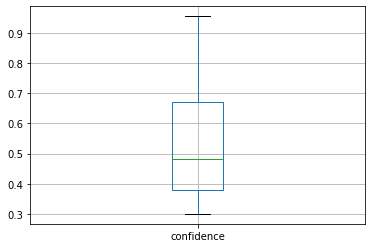

In [66]:
rules_c[['confidence']].boxplot()

Using Lift Threshold

In [67]:
rules_l.sort_values('lift', ascending = False, inplace = True)
rules_l.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
284,"(brown, labour)","(election, chancellor)",0.013933,0.009888,0.008090,0.580645,58.724340,0.007952,2.361037
289,"(election, chancellor)","(brown, labour)",0.009888,0.013933,0.008090,0.818182,58.724340,0.007952,5.423371
303,"(chancellor, blair)","(brown, labour)",0.008090,0.013933,0.005843,0.722222,51.836918,0.005730,3.549843
298,"(brown, labour)","(chancellor, blair)",0.013933,0.008090,0.005843,0.419355,51.836918,0.005730,1.708290
288,"(labour, chancellor)","(brown, election)",0.011685,0.013483,0.008090,0.692308,51.346154,0.007932,3.206180
285,"(brown, election)","(labour, chancellor)",0.013483,0.011685,0.008090,0.600000,51.346154,0.007932,2.470787
301,"(labour, chancellor)","(brown, blair)",0.011685,0.010787,0.005843,0.500000,46.354167,0.005717,1.978427
300,"(brown, blair)","(labour, chancellor)",0.010787,0.011685,0.005843,0.541667,46.354167,0.005717,2.156323
239,(chancellor),"(tax, brown)",0.021573,0.006742,0.006292,0.291667,43.263889,0.006147,1.402247
234,"(tax, brown)",(chancellor),0.006742,0.021573,0.006292,0.933333,43.263889,0.006147,14.676404


<AxesSubplot:>

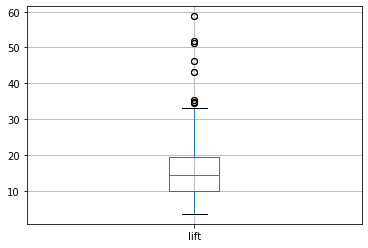

In [68]:
rules_l[['lift']].boxplot()

Both

In [69]:
# Option A
rules_c[ (rules_c['lift'] >= 2) &
 (rules_c['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
83,"(election, chancellor)",(brown),0.009888,0.028764,0.009438,0.954545,33.185369,0.009154,21.367191
148,"(labour, election, chancellor)",(brown),0.008539,0.028764,0.008090,0.947368,32.935855,0.007844,18.453483
116,"(chancellor, blair)",(brown),0.008090,0.028764,0.007640,0.944444,32.834201,0.007408,17.482247
119,"(tax, chancellor)",(brown),0.006742,0.028764,0.006292,0.933333,32.447917,0.006098,14.568539
118,"(tax, brown)",(chancellor),0.006742,0.021573,0.006292,0.933333,43.263889,0.006147,14.676404
...,...,...,...,...,...,...,...,...,...
3,(oil),(bn),0.020225,0.056629,0.007191,0.355556,6.278660,0.006046,1.463851
46,(economic),(growth),0.020225,0.026067,0.007191,0.355556,13.639847,0.006664,1.511275
117,(chancellor),"(brown, blair)",0.021573,0.010787,0.007640,0.354167,32.834201,0.007408,1.531685
36,(rate),(economy),0.024270,0.029663,0.008539,0.351852,11.861672,0.007819,1.497091


In [70]:
# Option B
rules_l[ (rules_l['lift'] >= 2) &
 (rules_l['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
284,"(brown, labour)","(election, chancellor)",0.013933,0.009888,0.008090,0.580645,58.724340,0.007952,2.361037
289,"(election, chancellor)","(brown, labour)",0.009888,0.013933,0.008090,0.818182,58.724340,0.007952,5.423371
303,"(chancellor, blair)","(brown, labour)",0.008090,0.013933,0.005843,0.722222,51.836918,0.005730,3.549843
298,"(brown, labour)","(chancellor, blair)",0.013933,0.008090,0.005843,0.419355,51.836918,0.005730,1.708290
288,"(labour, chancellor)","(brown, election)",0.011685,0.013483,0.008090,0.692308,51.346154,0.007932,3.206180
...,...,...,...,...,...,...,...,...,...
170,"(tory, howard)",(election),0.013933,0.045843,0.005843,0.419355,9.147691,0.005204,1.643271
21,(blair),(election),0.037303,0.045843,0.013483,0.361446,7.884479,0.011773,1.494246
10,(profit),(bn),0.022921,0.056629,0.009888,0.431373,7.617491,0.008590,1.659031
0,(award),(film),0.040449,0.063820,0.019326,0.477778,7.486307,0.016744,1.792685


 Visualise the Data


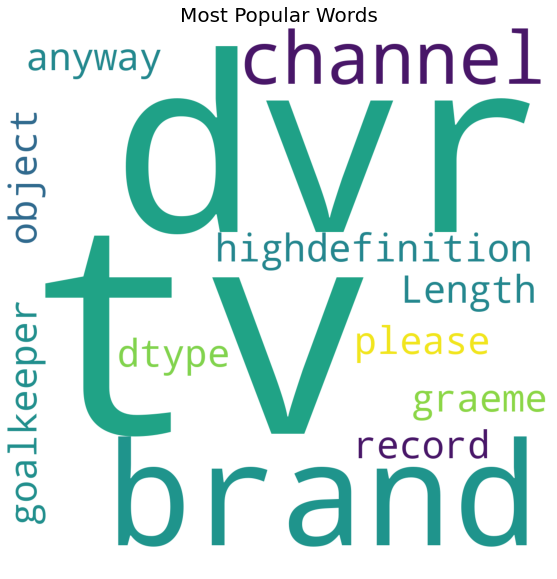

In [71]:
# Word Cloud
# pip install wordcloud
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200, height = 1200, max_words = 500).generate(str(full_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words',fontsize = 20)
plt.show()


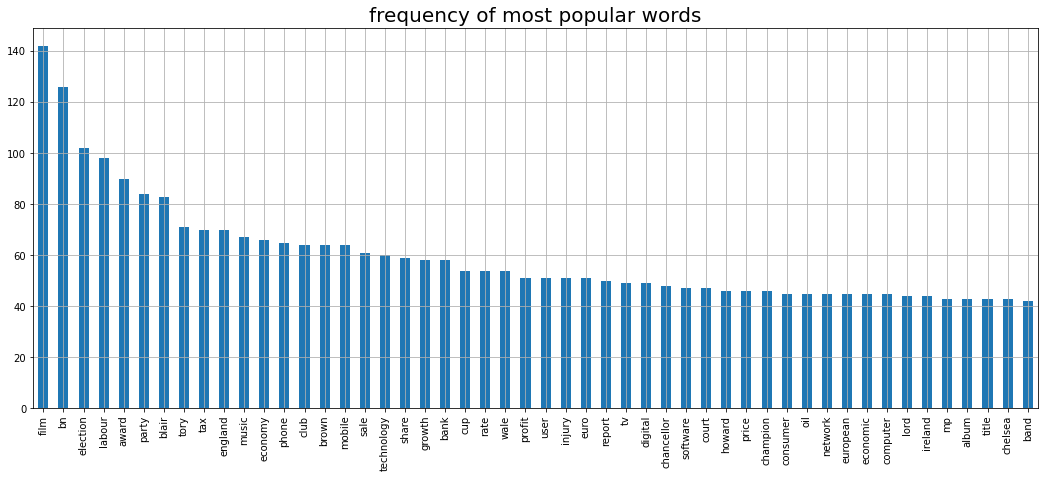

In [72]:
# looking at the frequency of most popular items
plt.figure(figsize=(18,7))
full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular words', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()


sports category

preprocess data

In [73]:

# making each customers shopping items an identical list
trans1 = [[]for y1 in range(len(sport_results))]
for i in range(len(sport_results)):
    for key in sport_results[i]:
        if dat['category'][i] == 'sport':
            trans1[i].append(key)

# conveting it into an numpy array
trans1 = np.array(trans1)

# checking the shape of the array
print(trans1.shape)

(511,)


C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/4293371585.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans1 = np.array(trans1)


In [74]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded1 = te.fit_transform(trans1)
data_encoded1 = pd.DataFrame(data_encoded1, columns = te.columns_)
# getting the shape of the data
data_encoded1.shape

(511, 1158)

In [75]:
data_encoded1

,aaa,absent,ac,accident,accommodate,ace,achilles,act,adapt,adelaide,...,wrist,wru,wta,yannick,yapp,yard,yelling,youth,zealand,zealander
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
507,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
508,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
509,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [76]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded1 = data_encoded1.loc[:, y1.index]
# checking the shape
data_encoded1.shape


(511, 50)

In [77]:
data_encoded1

,england,cup,injury,club,champion,wale,chelsea,ireland,match,rugby,...,football,squad,indoor,jones,ball,newcastle,beat,athletics,referee,tennis
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
507,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
508,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
509,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


aprirori algorithm

In [78]:
#First, let us return the items and itemsets with at least 0.5% support:
frequent_itemsets1=apriori(data_encoded1, min_support = 0.005, use_colnames = True)
frequent_itemsets1

,support,itemsets
0,0.037182,(england)
1,0.023483,(cup)
2,0.031311,(injury)
3,0.009785,(club)
4,0.023483,(champion)
...,...,...
76,0.005871,"(drug, test)"
77,0.007828,"(test, athens)"
78,0.005871,"(league, chelsea, cup)"
79,0.005871,"(league, liverpool, champion)"


In [79]:
frequent_itemsets1[['support']].describe()

,support
count,81.000000
mean,0.010558
std,0.006084
min,0.005871
25%,0.005871
50%,0.007828
75%,0.011742
max,0.037182


generate association rules

In [80]:
rules_c1 = association_rules(frequent_itemsets1, metric="confidence", min_threshold=0.3)
rules_c1


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(injury),(england),0.031311,0.037182,0.009785,0.312500,8.404605,0.008621,1.400463
1,(rugby),(england),0.015656,0.037182,0.007828,0.500000,13.447368,0.007246,1.925636
2,(robinson),(england),0.005871,0.037182,0.005871,1.000000,26.894737,0.005653,inf
3,(nation),(england),0.009785,0.037182,0.005871,0.600000,16.136842,0.005507,2.407045
4,(jones),(england),0.017613,0.037182,0.005871,0.333333,8.964912,0.005216,1.444227
...,...,...,...,...,...,...,...,...,...
56,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
57,"(test, athens)",(drug),0.007828,0.015656,0.005871,0.750000,47.906250,0.005748,3.937378
58,(drug),"(test, athens)",0.015656,0.007828,0.005871,0.375000,47.906250,0.005748,1.587476
59,(test),"(drug, athens)",0.009785,0.005871,0.005871,0.600000,102.200000,0.005813,2.485323


In [81]:
rules_l1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=1)
rules_l1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(cup),(england),0.023483,0.037182,0.005871,0.250000,6.723684,0.004998,1.283757
1,(england),(cup),0.037182,0.023483,0.005871,0.157895,6.723684,0.004998,1.159614
2,(injury),(england),0.031311,0.037182,0.009785,0.312500,8.404605,0.008621,1.400463
3,(england),(injury),0.037182,0.031311,0.009785,0.263158,8.404605,0.008621,1.314649
4,(wale),(england),0.021526,0.037182,0.005871,0.272727,7.334928,0.005070,1.323875
...,...,...,...,...,...,...,...,...,...
81,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
82,"(test, athens)",(drug),0.007828,0.015656,0.005871,0.750000,47.906250,0.005748,3.937378
83,(drug),"(test, athens)",0.015656,0.007828,0.005871,0.375000,47.906250,0.005748,1.587476
84,(test),"(drug, athens)",0.009785,0.005871,0.005871,0.600000,102.200000,0.005813,2.485323


using confidence threshold

In [82]:
rules_c1.sort_values('confidence', ascending = False, inplace = True)
rules_c1.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.00,102.200000,0.005813,inf
2,(robinson),(england),0.005871,0.037182,0.005871,1.00,26.894737,0.005653,inf
50,"(league, liverpool)",(champion),0.005871,0.023483,0.005871,1.00,42.583333,0.005733,inf
47,"(chelsea, cup)",(league),0.005871,0.015656,0.005871,1.00,63.875000,0.005779,inf
52,"(liverpool, champion)",(league),0.005871,0.015656,0.005871,1.00,63.875000,0.005779,inf
46,"(league, cup)",(chelsea),0.005871,0.019569,0.005871,1.00,51.100000,0.005756,inf
55,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.00,85.166667,0.005802,inf
43,(test),(athens),0.009785,0.011742,0.007828,0.80,68.133333,0.007713,4.941292
57,"(test, athens)",(drug),0.007828,0.015656,0.005871,0.75,47.906250,0.005748,3.937378
51,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.75,76.650000,0.005794,3.960861


<AxesSubplot:>

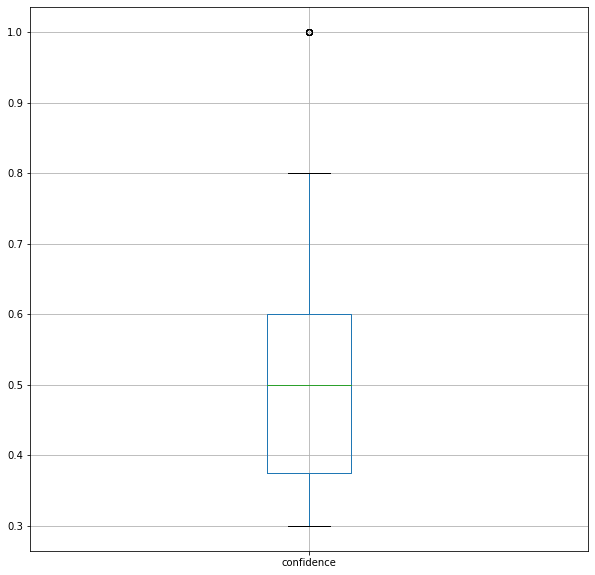

In [83]:
rules_c1[['confidence']].boxplot()

using lift threshold

In [84]:
rules_l1.sort_values('lift', ascending = False, inplace = True)
rules_l1.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,(test),"(drug, athens)",0.009785,0.005871,0.005871,0.600000,102.200000,0.005813,2.485323
81,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
85,(athens),"(drug, test)",0.011742,0.005871,0.005871,0.500000,85.166667,0.005802,1.988258
80,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.000000,85.166667,0.005802,inf
78,(liverpool),"(league, champion)",0.009785,0.007828,0.005871,0.600000,76.650000,0.005794,2.480431
75,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.750000,76.650000,0.005794,3.960861
66,(test),(athens),0.009785,0.011742,0.007828,0.800000,68.133333,0.007713,4.941292
67,(athens),(test),0.011742,0.009785,0.007828,0.666667,68.133333,0.007713,2.970646
71,(league),"(chelsea, cup)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607
77,(league),"(liverpool, champion)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607


<AxesSubplot:>

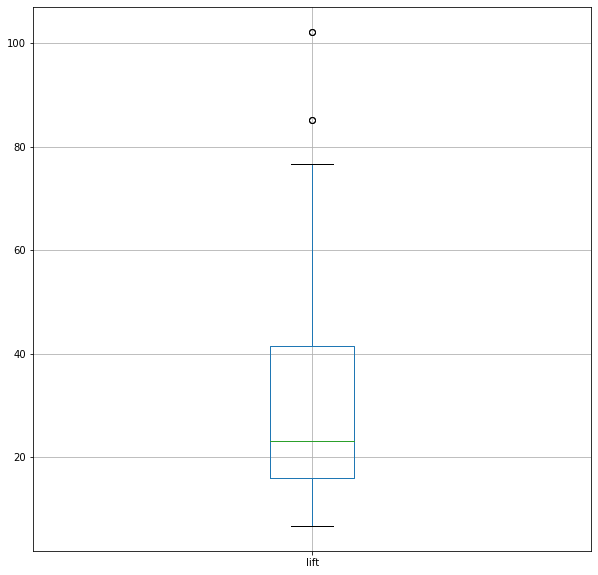

In [85]:
rules_l1[['lift']].boxplot()

both

In [86]:
# Option A
rules_c1[ (rules_c1['lift'] >= 2) &
 (rules_c1['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
2,(robinson),(england),0.005871,0.037182,0.005871,1.000000,26.894737,0.005653,inf
50,"(league, liverpool)",(champion),0.005871,0.023483,0.005871,1.000000,42.583333,0.005733,inf
47,"(chelsea, cup)",(league),0.005871,0.015656,0.005871,1.000000,63.875000,0.005779,inf
52,"(liverpool, champion)",(league),0.005871,0.015656,0.005871,1.000000,63.875000,0.005779,inf
46,"(league, cup)",(chelsea),0.005871,0.019569,0.005871,1.000000,51.100000,0.005756,inf
55,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.000000,85.166667,0.005802,inf
43,(test),(athens),0.009785,0.011742,0.007828,0.800000,68.133333,0.007713,4.941292
57,"(test, athens)",(drug),0.007828,0.015656,0.005871,0.750000,47.906250,0.005748,3.937378
51,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.750000,76.650000,0.005794,3.960861


In [87]:
# Option B
rules_l1[ (rules_l1['lift'] >= 2) &
 (rules_l1['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,(test),"(drug, athens)",0.009785,0.005871,0.005871,0.600000,102.200000,0.005813,2.485323
81,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
85,(athens),"(drug, test)",0.011742,0.005871,0.005871,0.500000,85.166667,0.005802,1.988258
80,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.000000,85.166667,0.005802,inf
78,(liverpool),"(league, champion)",0.009785,0.007828,0.005871,0.600000,76.650000,0.005794,2.480431
75,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.750000,76.650000,0.005794,3.960861
66,(test),(athens),0.009785,0.011742,0.007828,0.800000,68.133333,0.007713,4.941292
67,(athens),(test),0.011742,0.009785,0.007828,0.666667,68.133333,0.007713,2.970646
71,(league),"(chelsea, cup)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607
77,(league),"(liverpool, champion)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607


visualise the data

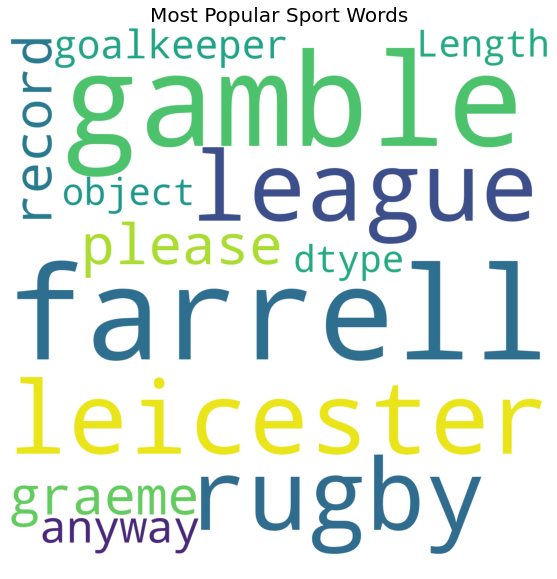

In [88]:
# Word Cloud
# pip install wordcloud
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200, height = 1200, max_words = 500).generate(str(sport_full_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Sport Words',fontsize = 20)
plt.show()


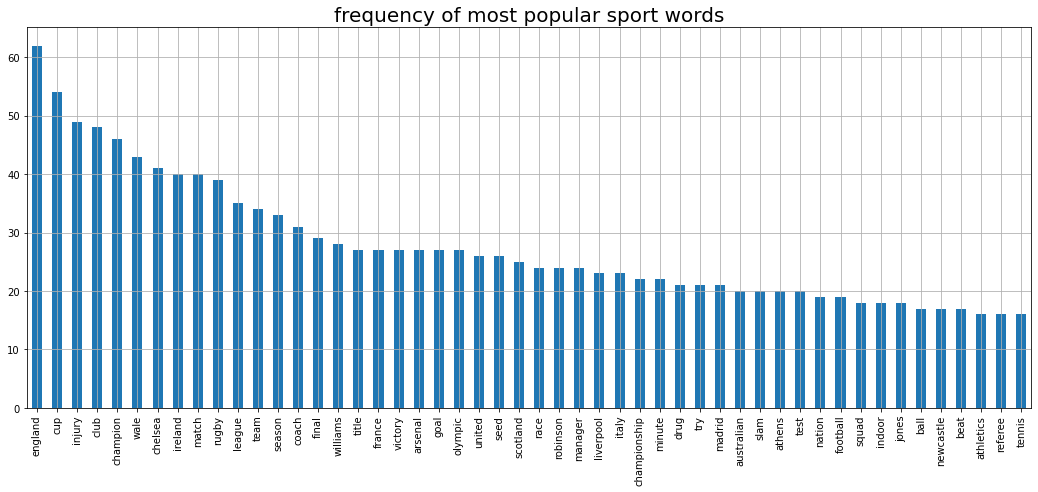

In [89]:
# looking at the frequency of most popular items
plt.figure(figsize=(18,7))
sport_full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular sport words', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

business category

In [112]:

# making each customers shopping items an identical list
trans2 = [[]for y2 in range(len(biz_results))]
for i in range(len(biz_results)):
    for key in biz_results[i]:
        if dat['category'][i] == 'business':
            trans2[i].append(key)

# conveting it into an numpy array
trans2 = np.array(trans2)

# checking the shape of the array
print(trans2.shape)

(510,)


C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/4169608708.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans2 = np.array(trans2)


In [113]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded2 = te.fit_transform(trans2)
data_encoded2 = pd.DataFrame(data_encoded2, columns = te.columns_)
# getting the shape of the data
data_encoded2.shape

(510, 1166)

In [114]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded2 = data_encoded2.loc[:, y2.index]
# checking the shape
data_encoded2.shape


(510, 50)

In [115]:
data_encoded2

,bn,economy,share,growth,bank,profit,rate,oil,euro,sale,...,court,indian,deutsche,export,shareholder,russia,stake,president,bankruptcy,japan
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
506,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
507,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
508,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


aprirori algorithm

In [94]:
#First, let us return the items and itemsets with at least 0.5% support:
frequent_itemsets2=apriori(data_encoded2, min_support = 0.005, use_colnames = True)
frequent_itemsets2

,support,itemsets
0,0.052941,(bn)
1,0.035294,(economy)
2,0.031373,(share)
3,0.033333,(growth)
4,0.021569,(bank)
...,...,...
100,0.005882,"(growth, economy, economist)"
101,0.005882,"(rate, growth, economist)"
102,0.007843,"(yukos, oil, russian)"
103,0.007843,"(yukos, russia, oil)"


In [95]:
frequent_itemsets2[['support']].describe()

,support
count,105.000000
mean,0.011317
std,0.007830
min,0.005882
25%,0.005882
50%,0.007843
75%,0.013725
max,0.052941


generate association rules

In [96]:
rules_c2 = association_rules(frequent_itemsets2, metric="confidence", min_threshold=0.3)
rules_c2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(profit),(bn),0.019608,0.052941,0.009804,0.500000,9.444444,0.008766,1.894118
1,(oil),(bn),0.031373,0.052941,0.013725,0.437500,8.263889,0.012065,1.683660
2,(sale),(bn),0.011765,0.052941,0.007843,0.666667,12.592593,0.007220,2.841176
3,(india),(bn),0.019608,0.052941,0.005882,0.300000,5.666667,0.004844,1.352941
4,(car),(bn),0.015686,0.052941,0.005882,0.375000,7.083333,0.005052,1.515294
...,...,...,...,...,...,...,...,...,...
102,"(bn, oil)","(yukos, russian)",0.013725,0.009804,0.005882,0.428571,43.714286,0.005748,1.732843
103,"(bn, russian)","(yukos, oil)",0.005882,0.011765,0.005882,1.000000,85.000000,0.005813,inf
104,"(russian, oil)","(yukos, bn)",0.007843,0.007843,0.005882,0.750000,95.625000,0.005821,3.968627
105,(yukos),"(russian, bn, oil)",0.013725,0.005882,0.005882,0.428571,72.857143,0.005802,1.739706


In [97]:
rules_l2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules_l2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(share),(bn),0.031373,0.052941,0.005882,0.187500,3.541667,0.004221,1.165611
1,(bn),(share),0.052941,0.031373,0.005882,0.111111,3.541667,0.004221,1.089706
2,(profit),(bn),0.019608,0.052941,0.009804,0.500000,9.444444,0.008766,1.894118
3,(bn),(profit),0.052941,0.019608,0.009804,0.185185,9.444444,0.008766,1.203209
4,(bn),(oil),0.052941,0.031373,0.013725,0.259259,8.263889,0.012065,1.307647
...,...,...,...,...,...,...,...,...,...
153,"(russian, oil)","(yukos, bn)",0.007843,0.007843,0.005882,0.750000,95.625000,0.005821,3.968627
154,(yukos),"(russian, bn, oil)",0.013725,0.005882,0.005882,0.428571,72.857143,0.005802,1.739706
155,(bn),"(yukos, russian, oil)",0.052941,0.007843,0.005882,0.111111,14.166667,0.005467,1.116176
156,(oil),"(yukos, bn, russian)",0.031373,0.005882,0.005882,0.187500,31.875000,0.005698,1.223529


using confidence threshold

In [98]:
rules_c2.sort_values('confidence', ascending = False, inplace = True)
rules_c2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
60,"(yukos, bn)",(oil),0.007843,0.031373,0.007843,1.0,31.875000,0.007597,inf
70,"(bn, russian)",(yukos),0.005882,0.013725,0.005882,1.0,72.857143,0.005802,inf
34,(economist),(growth),0.007843,0.033333,0.007843,1.0,30.000000,0.007582,inf
87,"(russian, oil)",(yukos),0.007843,0.013725,0.007843,1.0,72.857143,0.007735,inf
90,"(yukos, russia)",(oil),0.007843,0.031373,0.007843,1.0,31.875000,0.007597,inf
78,"(economy, economist)",(growth),0.005882,0.033333,0.005882,1.0,30.000000,0.005686,inf
92,"(russia, oil)",(yukos),0.007843,0.013725,0.007843,1.0,72.857143,0.007735,inf
96,"(yukos, bn, russian)",(oil),0.005882,0.031373,0.005882,1.0,31.875000,0.005698,inf
98,"(russian, bn, oil)",(yukos),0.005882,0.013725,0.005882,1.0,72.857143,0.005802,inf
81,"(rate, economist)",(growth),0.005882,0.033333,0.005882,1.0,30.000000,0.005686,inf


<AxesSubplot:>

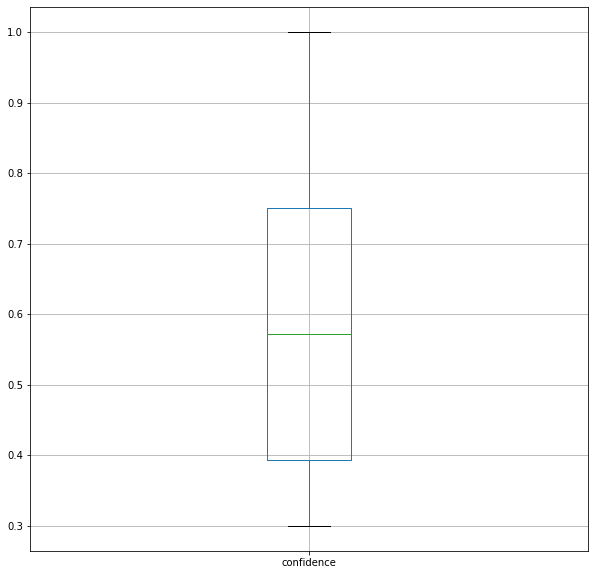

In [99]:
rules_c2[['confidence']].boxplot()

In [100]:
rules_l2.sort_values('lift', ascending = False, inplace = True)
rules_l2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
148,"(yukos, bn)","(russian, oil)",0.007843,0.007843,0.005882,0.750000,95.625000,0.005821,3.968627
153,"(russian, oil)","(yukos, bn)",0.007843,0.007843,0.005882,0.750000,95.625000,0.005821,3.968627
152,"(bn, russian)","(yukos, oil)",0.005882,0.011765,0.005882,1.000000,85.000000,0.005813,inf
149,"(yukos, oil)","(bn, russian)",0.011765,0.005882,0.005882,0.500000,85.000000,0.005813,1.988235
157,(russian),"(yukos, bn, oil)",0.009804,0.007843,0.005882,0.600000,76.500000,0.005805,2.480392
108,"(yukos, bn)",(russian),0.007843,0.009804,0.005882,0.750000,76.500000,0.005805,3.960784
113,(russian),"(yukos, bn)",0.009804,0.007843,0.005882,0.600000,76.500000,0.005805,2.480392
144,"(yukos, bn, oil)",(russian),0.007843,0.009804,0.005882,0.750000,76.500000,0.005805,3.960784
90,(yukos),(russian),0.013725,0.009804,0.009804,0.714286,72.857143,0.009669,3.465686
141,(yukos),"(russia, oil)",0.013725,0.007843,0.007843,0.571429,72.857143,0.007735,2.315033


<AxesSubplot:>

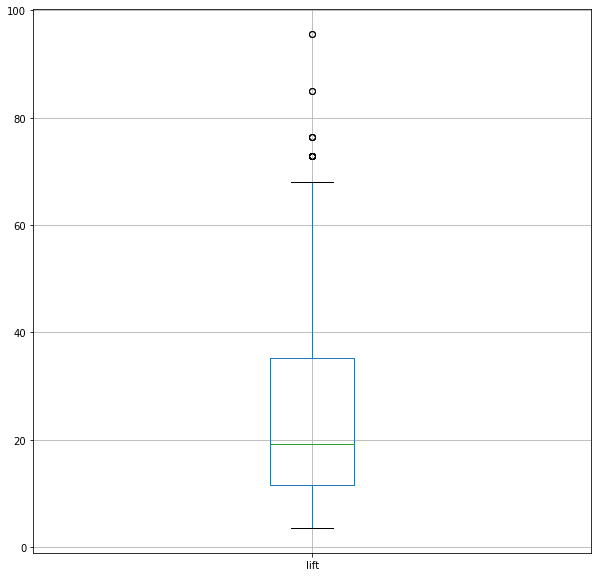

In [101]:
rules_l2[['lift']].boxplot()

In [102]:
# Option A
rules_c1[ (rules_c1['lift'] >= 2) &
 (rules_c1['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
56,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
2,(robinson),(england),0.005871,0.037182,0.005871,1.000000,26.894737,0.005653,inf
50,"(league, liverpool)",(champion),0.005871,0.023483,0.005871,1.000000,42.583333,0.005733,inf
47,"(chelsea, cup)",(league),0.005871,0.015656,0.005871,1.000000,63.875000,0.005779,inf
52,"(liverpool, champion)",(league),0.005871,0.015656,0.005871,1.000000,63.875000,0.005779,inf
46,"(league, cup)",(chelsea),0.005871,0.019569,0.005871,1.000000,51.100000,0.005756,inf
55,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.000000,85.166667,0.005802,inf
43,(test),(athens),0.009785,0.011742,0.007828,0.800000,68.133333,0.007713,4.941292
57,"(test, athens)",(drug),0.007828,0.015656,0.005871,0.750000,47.906250,0.005748,3.937378
51,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.750000,76.650000,0.005794,3.960861


In [103]:
# Option B
rules_l1[ (rules_l1['lift'] >= 2) &
 (rules_l1['confidence'] >= 0.35) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
84,(test),"(drug, athens)",0.009785,0.005871,0.005871,0.600000,102.200000,0.005813,2.485323
81,"(drug, athens)",(test),0.005871,0.009785,0.005871,1.000000,102.200000,0.005813,inf
85,(athens),"(drug, test)",0.011742,0.005871,0.005871,0.500000,85.166667,0.005802,1.988258
80,"(drug, test)",(athens),0.005871,0.011742,0.005871,1.000000,85.166667,0.005802,inf
78,(liverpool),"(league, champion)",0.009785,0.007828,0.005871,0.600000,76.650000,0.005794,2.480431
75,"(league, champion)",(liverpool),0.007828,0.009785,0.005871,0.750000,76.650000,0.005794,3.960861
66,(test),(athens),0.009785,0.011742,0.007828,0.800000,68.133333,0.007713,4.941292
67,(athens),(test),0.011742,0.009785,0.007828,0.666667,68.133333,0.007713,2.970646
71,(league),"(chelsea, cup)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607
77,(league),"(liverpool, champion)",0.015656,0.005871,0.005871,0.375000,63.875000,0.005779,1.590607


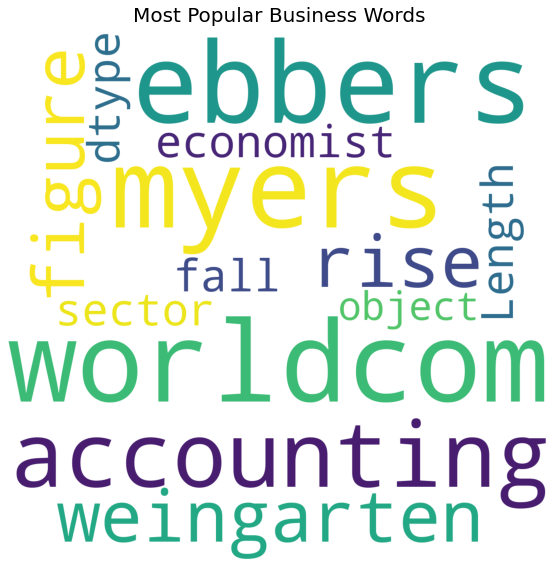

In [104]:
# Word Cloud
# pip install wordcloud
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200, height = 1200, max_words = 500).generate(str(biz_full_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Business Words',fontsize = 20)
plt.show()


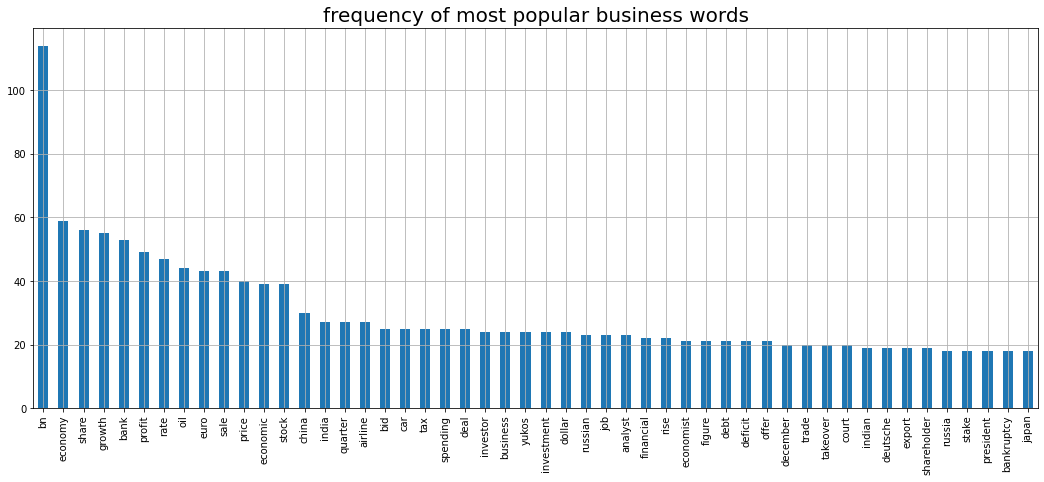

In [105]:
# looking at the frequency of most popular items
plt.figure(figsize=(18,7))
biz_full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular business words', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

politics category

In [144]:

# making each customers shopping items an identical list
trans3 = [[]for y3 in range(len(pol_results))]
for i in range(len(pol_results)):
    for key in pol_results[i]:
        if dat['category'][i] == 'politics':
            trans3[i].append(key)

# conveting it into an numpy array
trans3 = np.array(trans3)

# checking the shape of the array
print(trans3.shape)

(417,)


C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/1511162034.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans3 = np.array(trans3)


In [145]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded3 = te.fit_transform(trans3)
data_encoded3 = pd.DataFrame(data_encoded3, columns = te.columns_)
# getting the shape of the data
data_encoded3.shape

(417, 833)

In [146]:
data_encoded3

,abbas,ability,abortion,accept,accidentally,act,ad,adult,africa,age,...,winner,winning,winter,woman,worker,worry,writer,writing,wrong,yes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
413,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
414,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
415,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded3 = data_encoded3.loc[:, y3.index]
# checking the shape
data_encoded3.shape


tech category

In [120]:

# making each customers shopping items an identical list
trans4 = [[]for y4 in range(len(tech_results))]
for i in range(len(tech_results)):
    for key in tech_results[i]:
        if dat['category'][i] == 'tech':
            trans4[i].append(key)

# conveting it into an numpy array
trans4 = np.array(trans4)

# checking the shape of the array
print(trans4.shape)

(401,)


C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/3180070226.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans4 = np.array(trans4)


In [121]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded4 = te.fit_transform(trans4)
data_encoded4 = pd.DataFrame(data_encoded4, columns = te.columns_)
# getting the shape of the data
data_encoded4.shape

(401, 581)

In [ ]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded4 = data_encoded4.loc[:, y4.index]
# checking the shape
data_encoded4.shape


entertainment category

In [123]:

# making each customers shopping items an identical list
trans5 = [[]for y5 in range(len(ent_results))]
for i in range(len(ent_results)):
    for key in ent_results[i]:
        if dat['category'][i] == 'entertainment':
            trans5[i].append(key)

# conveting it into an numpy array
trans5 = np.array(trans5)

# checking the shape of the array
print(trans5.shape)

(386,)


C:\Users\gwenx\AppData\Local\Temp/ipykernel_8104/3332804333.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trans5 = np.array(trans5)


In [124]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array

te = TransactionEncoder()
data_encoded5 = te.fit_transform(trans5)
data_encoded5 = pd.DataFrame(data_encoded5, columns = te.columns_)
# getting the shape of the data
data_encoded5.shape

(386, 738)

In [ ]:
# getting correlations for 3067 items would be messy
# so let's reduce the items from 121 to 50
data_encoded5 = data_encoded5.loc[:, y5.index]
# checking the shape
data_encoded5.shape


# Problem2

## 3. Classification Modeling

### 3.1 Sample the data

### Use Word Counts as model input


In [ ]:
#X = reviews_tfidf.toarray()
X = text_counts.toarray()
y = dat['category'].map( {'sport': 0, 'business': 1, 'politics':2, 'tech':3, 'entertainment':4} ).astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
# Set the random state as 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


### Use TF-IDF matrix as model input


In [ ]:
X2 = text_tfidf.toarray()
y = dat['category'].map( {'sport': 0, 'business': 1, 'politics':2, 'tech':3, 'entertainment':4} ).astype(int)


In [ ]:
# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (30%)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=5)


### 3.2 Build the Model(s)

Model 1 - Word count as model input - logistics model with gridsearch



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(solver = 'lbfgs', max_iter =1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver = 'lbfgs', max_iter =1000), param_grid, cv=5)

grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


In [ ]:
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))


In [ ]:
y1_pred = grid.predict(X_test)

Model 2 - TF-IDF - logistics model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(solver = 'lbfgs', max_iter =1000), X2_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver = 'lbfgs', max_iter =1000), param_grid, cv=5)
grid.fit(X2_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)


In [ ]:
print("Test score: {:.2f}".format(grid.score(X2_test, y_test)))


In [ ]:
y2_pred = grid.predict(X2_test)

### 3.3 Evaluate and Improve the Model(s)

word count

In [ ]:
print(classification_report(y_test,y1_pred))

In [ ]:
print(accuracy_score(y_test,y1_pred))

tf-idf

In [ ]:
print(classification_report(y_test,y2_pred))

In [ ]:
print(accuracy_score(y_test,y2_pred))